# Well Count Graphs

This notebook should help inform where wells are in the state and their proximity to streams

In [1]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import seaborn as sns
import math
import dask.dataframe as dd
import dask_geopandas as dgp
import gc
import time

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'




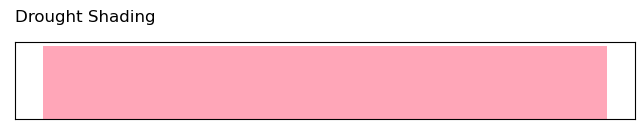

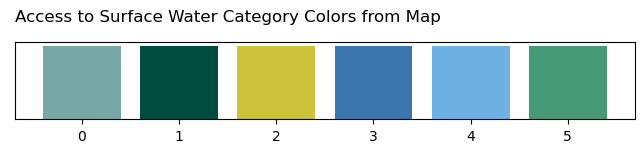

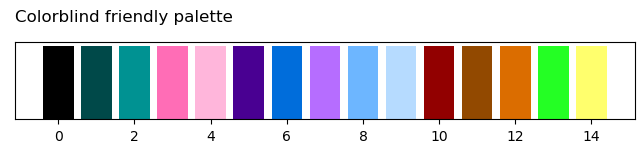

In [29]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

In [37]:
filename = "HUC4sShallowGWWellCountSummary.csv"
filepath = os.path.join(outputpath, filename)
boundaries_stats = pd.read_csv(filepath)
boundaries_stats = boundaries_stats.rename(columns={"huc4_wb":"huc4"})
boundaries_stats = boundaries_stats.drop(['Unnamed: 0'], axis=1)
boundaries_stats

,Decade,huc4,DTW_Category,Well Count
0,1980,1501,Deep (10-61m),108
1,1980,1501,Near Surface (<2m),116
2,1980,1501,Shallow (5-10m),37
3,1980,1501,Very Shallow (2-5m),29
4,1980,1502,Deep (10-61m),403
...,...,...,...,...
155,2020,1507,Very Shallow (2-5m),48
156,2020,1508,Deep (10-61m),42
157,2020,1508,Near Surface (<2m),4
158,2020,1508,Shallow (5-10m),13


In [38]:
boundaries_stats.columns

Index(['Decade', 'huc4', 'DTW_Category', 'Well Count'], dtype='object')

In [39]:
distances = [100, 
             500, 
             1000, 
             1500, 
             2000
             ]

stats_distances = {}

for i in distances:
    filename = f"HUC4s_{i}_ShallowGWWellCountSummary.csv"
    filepath = os.path.join(outputpath, filename)
    stats_distances[f"{i}m"] = pd.read_csv(filepath)
    stats_distances[f"{i}m"] = stats_distances[f"{i}m"].drop(['Unnamed: 0'], axis=1)

In [40]:
stats_distances["100m"]

,Decade,huc4,DTW_Category,Well Count
0,1980,1501,Deep (10-61m),5
1,1980,1501,Near Surface (<2m),5
2,1980,1501,Shallow (5-10m),3
3,1980,1501,Very Shallow (2-5m),6
4,1980,1502,Deep (10-61m),38
...,...,...,...,...
152,2020,1507,Shallow (5-10m),9
153,2020,1507,Very Shallow (2-5m),2
154,2020,1508,Near Surface (<2m),3
155,2020,1508,Shallow (5-10m),8


In [41]:
# Merge all distance dataframes into boundaries_stats
for key, df in stats_distances.items():
    boundaries_stats = boundaries_stats.merge(df, on=["Decade", "huc4", "DTW_Category"], how="left", suffixes=("", f"_{key}"))

# Display the final merged dataframe
boundaries_stats.head()

,Decade,huc4,DTW_Category,Well Count,Well Count_100m,Well Count_500m,Well Count_1000m,Well Count_1500m,Well Count_2000m
0,1980,1501,Deep (10-61m),108,5.0,21,44,61,65
1,1980,1501,Near Surface (<2m),116,5.0,25,42,55,72
2,1980,1501,Shallow (5-10m),37,3.0,20,24,24,26
3,1980,1501,Very Shallow (2-5m),29,6.0,19,21,21,21
4,1980,1502,Deep (10-61m),403,38.0,152,254,301,337


In [ ]:
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']


In [ ]:
boundaries_stats

In [28]:
# Summing all HUCs together by Decade and DTW_Category
summary_table = boundaries_stats.groupby(["Decade", "DTW_Category"]).sum().reset_index()

# Display the summary table
summary_table.head()


,Decade,DTW_Category,huc4,Well Count,Well Count_100m,Well Count_500m,Well Count_1000m,Well Count_1500m,Well Count_2000m
0,1980,Deep (10-61m),12036,6509,683.0,2604,3913,4604,5089
1,1980,Near Surface (<2m),12036,1740,256.0,665,924,1119,1263
2,1980,Shallow (5-10m),12036,2665,528.0,1643,2059,2246,2383
3,1980,Very Shallow (2-5m),12036,1944,363.0,1003,1276,1440,1568
4,1990,Deep (10-61m),12036,10048,716.0,2986,4386,5384,6041


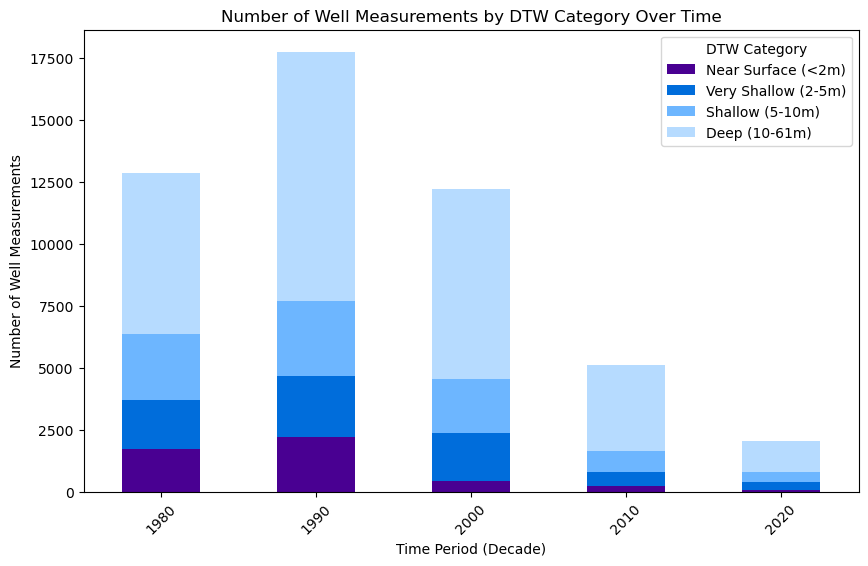

In [33]:
# Pivot the data to get each DTW category as a separate column for stacking
summary_pivot = summary_table.pivot(index='Decade', columns='DTW_Category', values='Well Count').fillna(0)

# Define the desired order for DTW categories
category_order = ['Near Surface (<2m)', 'Very Shallow (2-5m)', 'Shallow (5-10m)', 'Deep (10-61m)']

# Reorder the columns in summary_pivot
summary_pivot = summary_pivot[category_order]

# Define colors
colors = {
    'Near Surface (<2m)': cblind[5],
    'Very Shallow (2-5m)': cblind[6],
    'Shallow (5-10m)': cblind[8],
    'Deep (10-61m)': cblind[9]
}

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax)

# Labels and title
plt.xlabel('Time Period (Decade)')
plt.ylabel('Number of Well Measurements')
plt.title('Number of Well Measurements by DTW Category Over Time')
plt.legend(title='DTW Category')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

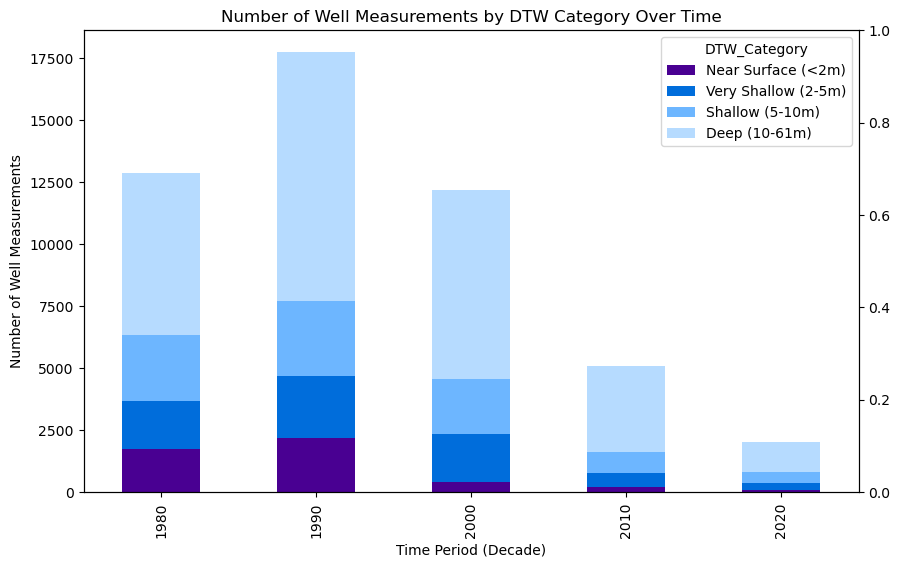

In [35]:
# Compute well counts per distance
distance_columns = [f"Well Count_{d}m" for d in distances]  # Adjust based on your column names
distance_sums = summary_table.groupby("Decade")[distance_columns].sum()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot
summary_pivot.plot(kind='bar', stacked=True, color=[colors[c] for c in summary_pivot.columns], ax=ax1)
ax1.set_xlabel("Time Period (Decade)")
ax1.set_ylabel("Number of Well Measurements")
ax1.set_title("Number of Well Measurements by DTW Category Over Time")

# Create a second y-axis for well counts per distance
ax2 = ax1.twinx()
for dist in distances:
    column_name = f"Well Count_{dist}m"
    ax2.plot(distance_sums.index, distance_sums[column_name], marker="o", label=f"{dist}m", linestyle="dashed")

ax2.set_ylabel("Total Well Counts by Distance")
ax2.legend(title="Buffer Distance", loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

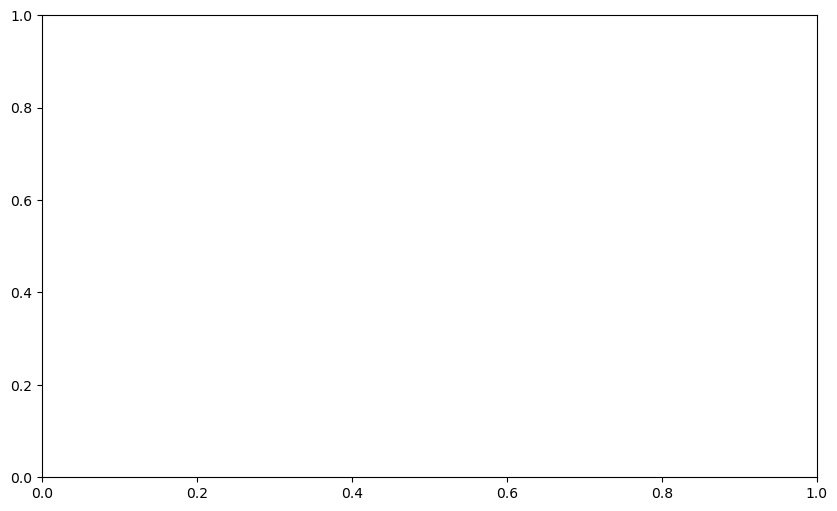

In [36]:
# Compute well counts per distance
distance_columns = [f"Well Count_{d}m" for d in distances]  # Adjust based on your column names
distance_sums = summary_table.groupby("Decade")[distance_columns].sum()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each distance as a separate line
for dist in distances:
    column_name = f"Well Count_{dist}m"
    if column_name in distance_sums.columns:  # Ensure column exists
        ax.plot(distance_sums.index, distance_sums[column_name], marker="o", linestyle="-", label=f"{dist}m")

# Labels and title
ax.set_xlabel("Time Period (Decade)")
ax.set_ylabel("Number of Well Measurements")
ax.set_title("Well Measurements Over Time by Distance")
ax.legend(title="Buffer Distance")

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
